In [9]:
import gymnasium as gym
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

env = gym.make('Taxi-v3')
n_states = env.observation_space.n
n_actions = env.action_space.n


policy = np.ones((n_states, n_actions)) / n_actions
gamma = 0.9  # discount factor
theta = 1e-3  # threshold for policy evaluation

def policy_evaluation(policy, env, gamma, theta):
    V = np.zeros(n_states)
    while True:
        delta = 0
        for s in range(n_states):
            v = 0
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    v += policy[s, a] * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        if delta < theta:
            break
    return V

def policy_improvement(V, env, gamma):
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        Q = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                Q[a] += prob * (reward + gamma * V[next_state])
        best_action = np.argmax(Q)
        policy[s, best_action] = 1.0
    return policy

def policy_iteration(env, gamma, theta):
    policy = np.ones((n_states, n_actions)) / n_actions
    while True:
        V = policy_evaluation(policy, env, gamma, theta)
        new_policy = policy_improvement(V, env, gamma)
        if np.array_equal(new_policy, policy):
            break
        policy = new_policy
    return policy, V

# Perform policy iteration to find the optimal policy and value function
optimal_policy, V_star = policy_iteration(env, gamma, theta)
V_optimal = policy_evaluation(optimal_policy, env, gamma, theta)

print("Optimal Policy:")
print(optimal_policy)
print("Optimal Value Function V*:")
print(V_optimal)

# Select the starting state s0
s0 = 0

print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")


Optimal Policy:
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
Optimal Value Function V*:
[ 89.47173769  32.81719251  55.26171741  37.57388511   8.43072799
  32.81719251   8.42970771  15.28080619  32.81821279  18.09133972
  55.26171741  21.21182645  12.75444177  18.09133972  12.75342148
  37.57388511 100.52456392  37.57528467  62.51364567  42.8607315
  79.52456392  28.53547326  48.73554567  32.8164966   10.47899759
  37.57528467  10.47807934  18.09064381  28.53639151  15.28220575
  48.73554567  18.09064381  15.28312401  21.21322602  15.28220575
  42.8607315   89.47210753  42.8619911   55.2622811   48.73491935
  42.86281753  12.75398518  24.68192593  15.28157943  24.68275236
  70.5712811   24.68192593  37.57465835  24.68275236  12.75398518
  42.8619911   15.28157943  18.09272984  24.68192593  18.09190342
  48.73491935  48.73679678  79.52415299  48.73605299  55.26171741
  37.57653578  10.47858666  21.213

In [10]:
# Define parameters for PGA
epsilon = 0.001
alpha = 0.01  # learning rate
num_iterations = 10000

def value_function(policy, env, gamma):
    V = np.zeros(n_states)
    while True:
        delta = 0
        for s in range(n_states):
            v = 0
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    v += policy[s, a] * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        if delta < 1e-6:
            break
    return V

def policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_star, s0, epsilon):
    V_history = []  # List to store value function at each iteration
    for i in tqdm(range(num_iterations)):
        V = value_function(policy, env, gamma)
        V_history.append(V.copy())  # Store the current value of V
        Q = np.zeros((n_states, n_actions))
        for s in range(n_states):
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    Q[s, a] += prob * (reward + gamma * V[next_state])
        
        # Policy Gradient Ascent
        for s in range(n_states):
            grad = Q[s] - np.sum(policy[s] * Q[s])
            policy[s] = policy[s] + alpha * grad
            policy[s] = np.maximum(policy[s], 0)
            policy[s] /= np.sum(policy[s])  # Project back to simplex
        
        # Check if we are within epsilon of the optimal value function
        if abs(V_star[s0] - V[s0]) <= epsilon:
            print(f"Stopping early at iteration {i} as V(s0) is within epsilon of V*(s0).")
            break
    return policy, V, V_history

# Optimize policy using Projected Gradient Ascent
optimized_policy, V_opt, V_history = policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_optimal, s0, epsilon)

# Plot the evolution of V
plt.figure(figsize=(10, 6))
for s in range(n_states):
    plt.plot([V[s] for V in V_history], label=f'State {s}')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Evolution of Value Function V during Policy Gradient Ascent')
plt.legend()
plt.show()

print("Optimized Policy:")
print(optimized_policy)
print("Value Function of Optimized Policy:")
print(V_opt)

print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")
print(f"V(s0) for s0 = {s0}: {V_opt[s0]}")
print(f"Difference: {V_optimal[s0] - V_opt[s0]}")


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
# Assume initial state distribution is uniform
mu = np.ones(n_states) / n_states

# Calculate stationary distribution d_pi for the optimal policy
def compute_stationary_distribution(policy, env, gamma, theta):
    P = np.zeros((n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                P[s, next_state] += policy[s, a] * prob
    
    # Solve for stationary distribution
    A = np.eye(n_states) - gamma * P.T
    b = np.ones(n_states)
    d_pi = np.linalg.solve(A, b)
    d_pi /= np.sum(d_pi)  # Normalize
    return d_pi

d_pi_star = compute_stationary_distribution(optimal_policy, env, gamma, theta)

# Compute the distribution mismatch coefficient
distribution_mismatch = np.max(np.abs(d_pi_star / mu))

print("Distribution mismatch coefficient:")
print(distribution_mismatch)


Distribution mismatch coefficient:
3.4390000000000005


In [6]:
# Theoretical iteration complexity calculations
D_inf = distribution_mismatch
S = env.observation_space.n
A = env.action_space.n
gamma = 0.9
epsilon = 0.001

def theoretical_iterations_pga(D_inf, S, A, gamma, epsilon):
    return (D_inf**2 * S * A) / ((1 - gamma)**6 * epsilon**2)

def theoretical_iterations_spg(D_inf, S, A, gamma, epsilon):
    return (D_inf**2 * S**2 * A**2) / ((1 - gamma)**6 * epsilon**2)

def theoretical_iterations_npg(gamma, epsilon):
    return 2 / ((1 - gamma)**2 * epsilon)

# Theoretical iterations
theoretical_pga = theoretical_iterations_pga(D_inf, S, A, gamma, epsilon)
theoretical_spg = theoretical_iterations_spg(D_inf, S, A, gamma, epsilon)
theoretical_npg = theoretical_iterations_npg(gamma, epsilon)

# Print theoretical results
print(f"Theoretical Projected Gradient Ascent: {theoretical_pga}")
print(f"Theoretical Softmax Policy Gradient: {theoretical_spg}")
print(f"Theoretical Natural Policy Gradient: {theoretical_npg}")

Theoretical Projected Gradient Ascent: 2270730432000003.5
Theoretical Softmax Policy Gradient: 4.359802429440008e+17
Theoretical Natural Policy Gradient: 200000.0000000001


In [55]:
import gymnasium as gym
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v1', is_slippery=False)
n_states = env.observation_space.n
n_actions = env.action_space.n


policy = np.ones((n_states, n_actions)) / n_actions
gamma = 0.9  # discount factor
theta = 1e-6  # threshold for policy evaluation

def policy_evaluation(policy, env, gamma, theta):
    V = np.zeros(n_states)
    status = True
    i = 0
    while True and status:
        delta = 0
        for s in range(n_states):
            v = 0
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    v += policy[s, a] * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        if delta < theta:
            break
        i += 1
        if i == 10000:
            status = False
    return V

def policy_improvement(V, env, gamma):
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        Q = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                Q[a] += prob * (reward + gamma * V[next_state])
        best_action = np.argmax(Q)
        policy[s, best_action] = 1.0
    return policy

def policy_iteration(env, gamma, theta):
    policy = np.ones((n_states, n_actions)) / n_actions
    while True:
        V = policy_evaluation(policy, env, gamma, theta)
        new_policy = policy_improvement(V, env, gamma)
        if np.array_equal(new_policy, policy):
            break
        policy = new_policy
    return policy, V

# Perform policy iteration to find the optimal policy and value function
optimal_policy, V_star = policy_iteration(env, gamma, theta)
V_optimal = policy_evaluation(optimal_policy, env, gamma, theta)

print("Optimal Policy:")
print(optimal_policy)
print("Optimal Value Function V*:")
print(V_optimal)

# Select the starting state s0
s0 = 0

print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")


Optimal Policy:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
Optimal Value Function V*:
[0.59049 0.6561  0.729   0.6561  0.6561  0.      0.81    0.      0.729
 0.81    0.9     0.      0.      0.9     1.      0.     ]
V*(s0) for s0 = 0: 0.5904900000000002


  0%|          | 0/3000 [00:00<?, ?it/s]

V(s0) for iteration 0: 0.004475705697772594
V(s0) for iteration 1: 0.4402764406671015
V(s0) for iteration 2: 0.55995725872134
V(s0) for iteration 3: 0.5904900000000002
Stopping early at iteration 3 as V(s0) is within epsilon of V*(s0).


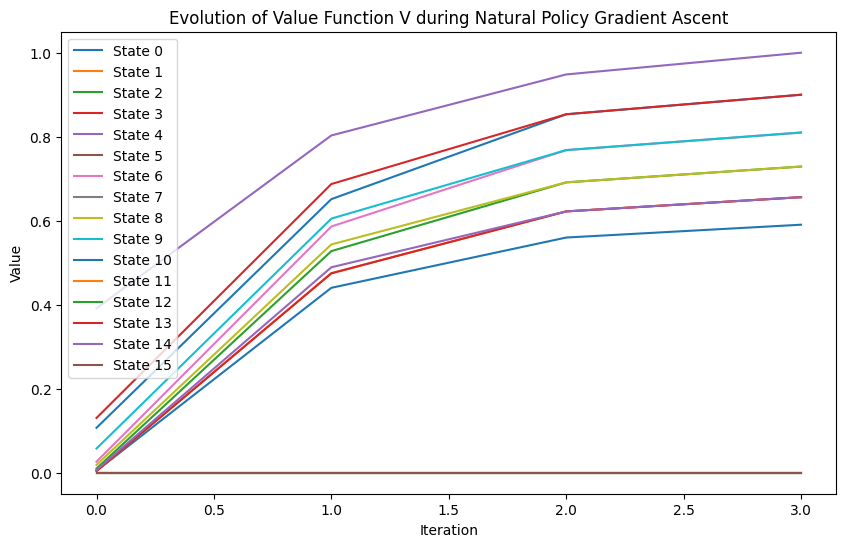

Optimized Policy:
[[0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.25 0.25 0.25 0.25]]
Value Function of Optimized Policy:
[0.59049 0.6561  0.729   0.6561  0.6561  0.      0.81    0.      0.729
 0.81    0.9     0.      0.      0.9     1.      0.     ]
V*(s0) for s0 = 0: 0.5904900000000002
V(s0) for s0 = 0: 0.5904900000000002
Difference: 0.0


In [56]:
epsilon = 0.001
alpha = 0.01  # learning rate
gamma = 0.9  # discount factor
num_iterations = 3000

policy = np.ones((n_states, n_actions)) / n_actions

def value_function(policy, env, gamma):
    V = np.zeros(n_states)
    while True:
        delta = 0
        for s in range(n_states):
            v = 0
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    v += policy[s, a] * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        if delta < 1e-6:
            break
    return V

def fisher_information_matrix(policy, env, gamma, V):
    FIM = np.zeros((n_states * n_actions, n_states * n_actions))
    Q = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                Q[s, a] += prob * (reward + gamma * V[next_state])
    for s in range(n_states):
        grad = Q[s] - np.sum(policy[s] * Q[s])
        grad = grad[:, np.newaxis]
        for i in range(n_actions):
            for j in range(n_actions):
                FIM[s * n_actions + i, s * n_actions + j] = np.sum(grad[i] * grad[j] * policy[s, i] * policy[s, j])
    return FIM

def policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_star, s0, epsilon):
    V_history = []  # List to store value function at each iteration
    for i in tqdm(range(num_iterations)):
        V = value_function(policy, env, gamma)
        V_history.append(V.copy())  # Store the current value of V
        Q = np.zeros((n_states, n_actions))
        for s in range(n_states):
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    Q[s, a] += prob * (reward + gamma * V[next_state])

        FIM = fisher_information_matrix(policy, env, gamma, V)
        FIM_inv = np.linalg.pinv(FIM)  # Compute the pseudo-inverse of FIM
        
        # Policy Gradient Ascent with Natural Gradient
        for s in range(n_states):
            grad = Q[s] - np.sum(policy[s] * Q[s])
            nat_grad = np.dot(FIM_inv[s * n_actions:(s + 1) * n_actions, s * n_actions:(s + 1) * n_actions], grad)
            policy[s] = policy[s] + alpha * nat_grad
            policy[s] = np.maximum(policy[s], 0)
            policy[s] /= np.sum(policy[s])  # Project back to simplex
        
        # Check if we are within epsilon of the optimal value function
        print(f"V(s0) for iteration {i}: {V[s0]}")
        if abs(V_star[s0] - V[s0]) <= epsilon:
            print(f"Stopping early at iteration {i} as V(s0) is within epsilon of V*(s0).")
            break
    return policy, V, V_history

# Optimize policy using Natural Policy Gradient Ascent
optimized_policy, V_opt, V_history = policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_optimal, s0, epsilon)

# Plot the evolution of V
plt.figure(figsize=(10, 6))
for s in range(n_states):
    plt.plot([V[s] for V in V_history], label=f'State {s}')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Evolution of Value Function V during Natural Policy Gradient Ascent')
plt.legend()
plt.show()

print("Optimized Policy:")
print(optimized_policy)
print("Value Function of Optimized Policy:")
print(V_opt)

print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")
print(f"V(s0) for s0 = {s0}: {V_opt[s0]}")
print(f"Difference: {V_optimal[s0] - V_opt[s0]}")

In [64]:
env = gym.make('CliffWalking-v0')
n_states = env.observation_space.n
n_actions = env.action_space.n

In [65]:
gamma_values = np.linspace(0.1, 0.9, 9)
iterations_store = {}
policy = np.ones((n_states, n_actions)) / n_actions
theta = 1e-3  # threshold for policy evaluation
for gamma in gamma_values[::-1]:
    print(f"Gamma: {gamma}")
    print((f"Epsilon: {epsilon}"))
    print(f"Theoretical Natural Policy Gradient: {theoretical_iterations_npg(gamma, epsilon)}")
    print("\n")
    policy = np.ones((n_states, n_actions)) / n_actions

    # Perform policy iteration to find the optimal policy and value function
    optimal_policy, V_star = policy_iteration(env, gamma, theta)
    V_optimal = policy_evaluation(optimal_policy, env, gamma, theta)

    print("Optimal Policy:")
    print(optimal_policy)
    print("Optimal Value Function V*:")
    print(V_optimal)

    print(f"V*(s0) for s0 = {s0}: {V_optimal[s0]}")
    # Optimize policy using Natural Policy Gradient Ascent
    optimized_policy, V_opt, V_history = policy_gradient_ascent(policy, env, alpha, gamma, num_iterations, V_optimal, s0, epsilon)
    iterations_store[gamma] = len(V_history)

Gamma: 0.9
Theoretical Natural Policy Gradient: 200000.0000000001


Optimal Policy:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
Optimal Value Function V*:
[-9.99140496 -9.99140496 -9.99140496 -9.99140496 -9.99140496 -9.99140496
 -9.99140496 -9.99140496 -9.99140496 -9.99140496 -9.99140496 -9.99140496
 -9.99226446 -9.992264

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
iterations_store

{0.9: 4,
 0.8: 5,
 0.7000000000000001: 5,
 0.6: 6,
 0.5: 6,
 0.4: 6,
 0.30000000000000004: 4,
 0.2: 1,
 0.1: 1}